In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.applications import inception_resnet_v2
from tensorflow.keras.applications.inception_resnet_v2 import preprocess_input
from tensorflow.keras.utils import img_to_array, array_to_img
from google.colab.patches import cv2_imshow
import os
import zipfile
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
import collections
import ast
import glob
from IPython.display import Image
import random
from sklearn.metrics import accuracy_score, roc_auc_score, confusion_matrix
from sklearn.metrics import roc_curve, auc
import time
import re

In [ ]:
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    os.environ['TF_DETERMINISTIC_OPS'] = '1'
    np.random.seed(seed)
    # TensorFlow의 시드 설정
    tf.random.set_seed(seed)  # TensorFlow의 시드 설정
seed_everything(42) # Seed 고정

In [ ]:
base_path='/content/drive/MyDrive/Dataset/MRI_dataset/Sharpening_data_2'

In [ ]:
df=pd.read_excel('/content/drive/MyDrive/Dataset/ADNI_tabular/ADNI_subjects.xlsx')
df

,PHASE,RID,PTID,EXAMDATE,Gender,Birthdate,Age,FINAL_DX,AD severity,Certain or Not,CDR,MMSCORE,Bilateral hippocampus,D_subtract,APGEN1,APGEN2,APOE carrier
0,ADNI2,5040,070_S_5040,2013-07-25,2,1936-12-01,77,normal cognition-NC,NaN,NaN,0.0,30,0.005795,0,3,3,0
1,ADNI2,295,002_S_0295,2011-06-02,1,1921-06-01,90,normal cognition-NC,NaN,NaN,0.0,28,0.004041,0,3,4,1
2,ADNI2,295,002_S_0295,2012-05-10,1,1921-06-01,91,normal cognition-NC,NaN,NaN,0.0,22,0.003914,0,3,4,1
3,ADNI1,413,002_S_0413,2006-05-19,2,1929-12-01,77,normal cognition,NaN,4.0,0.0,29,0.004400,0,3,3,0
4,ADNI1,413,002_S_0413,2006-11-15,2,1929-12-01,77,normal cognition,NaN,4.0,0.0,29,0.004296,0,3,3,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5187,ADNI3,6345,941_S_6345,2018-05-10,1,1939-01-01,79,MCI,NaN,NaN,0.5,28,0.003906,0,3,4,1
5188,ADNI3,6345,941_S_6345,2019-05-29,1,1939-01-01,80,Mild AD,1.0,NaN,1.0,24,0.003759,0,3,4,1
5189,ADNI3,6345,941_S_6345,2020-09-08,1,1939-01-01,82,Mild AD,1.0,NaN,1.0,22,0.003553,0,3,4,1
5190,ADNI3,6854,941_S_6854,2020-02-14,1,1933-11-01,86,Mild AD,1.0,NaN,0.5,30,0.003654,0,3,4,1


In [ ]:
df = df.drop(['PHASE','AD severity','Certain or Not','CDR'], axis=1)
df

,RID,PTID,EXAMDATE,Gender,Birthdate,Age,FINAL_DX,MMSCORE,Bilateral hippocampus,D_subtract,APGEN1,APGEN2,APOE carrier
0,5040,070_S_5040,2013-07-25,2,1936-12-01,77,normal cognition-NC,30,0.005795,0,3,3,0
1,295,002_S_0295,2011-06-02,1,1921-06-01,90,normal cognition-NC,28,0.004041,0,3,4,1
2,295,002_S_0295,2012-05-10,1,1921-06-01,91,normal cognition-NC,22,0.003914,0,3,4,1
3,413,002_S_0413,2006-05-19,2,1929-12-01,77,normal cognition,29,0.004400,0,3,3,0
4,413,002_S_0413,2006-11-15,2,1929-12-01,77,normal cognition,29,0.004296,0,3,3,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
5187,6345,941_S_6345,2018-05-10,1,1939-01-01,79,MCI,28,0.003906,0,3,4,1
5188,6345,941_S_6345,2019-05-29,1,1939-01-01,80,Mild AD,24,0.003759,0,3,4,1
5189,6345,941_S_6345,2020-09-08,1,1939-01-01,82,Mild AD,22,0.003553,0,3,4,1
5190,6854,941_S_6854,2020-02-14,1,1933-11-01,86,Mild AD,30,0.003654,0,3,4,1


In [ ]:
df[(df['PTID'] == '002_S_0295') & (df['EXAMDATE'] == '20110602')]

,RID,PTID,EXAMDATE,Gender,Birthdate,Age,FINAL_DX,MMSCORE,Bilateral hippocampus,D_subtract,APGEN1,APGEN2,APOE carrier
1,295,002_S_0295,2011-06-02,1,1921-06-01,90,normal cognition-NC,28,0.004041,0,3,4,1


In [ ]:
 #알집 해제
 #def open_zip(Data_path):
 #    os.chdir(Data_path)
 #    zip_files = os.listdir(Data_path)
 #    zip_files=[files for files in zip_files if '.zip' in files]
 #    for zip_file in zip_files:
 #        zipfile.ZipFile(os.path.join(Data_path,zip_file)).extractall()
 #    return os.listdir(Data_path)
 #data_listdir=open_zip(base_path)

In [ ]:

def fold_path(Data_path):
    fold = collections.defaultdict(list)
    os.chdir(Data_path)
    Data_list = os.listdir(Data_path)
    folder_list = [folder for folder in Data_list if os.path.isdir(os.path.join(Data_path, folder))]
    for folder in folder_list:
        # print(folder)
        files_in_folder=os.listdir(os.path.join(Data_path,folder))
        # print(files_in_folder)
        fold[folder] = files_in_folder
        print(fold)
    return fold

fold_data = fold_path(base_path)


defaultdict(<class 'list'>, {'Normal': ['002_S_0295_110602', '002_S_1261_110314', '002_S_0413_130510', '002_S_0413_140501', '002_S_0413_150609', '002_S_0295_120510', '002_S_0413_110616', '002_S_0413_120515', '002_S_1280_110504', '002_S_0685_110708', '002_S_1280_120301', '002_S_4213_110902', '002_S_4213_150929', '002_S_4213_120316', '002_S_1280_130226', '002_S_1280_150504', '002_S_4213_111205', '002_S_4213_130917', '002_S_4213_120919', '002_S_1280_140314', '002_S_4225_131017', '002_S_4225_120412', '002_S_4225_111226', '002_S_4264_111005', '002_S_4262_121025', '002_S_4262_120419', '002_S_4262_120102', '002_S_4262_111005', '002_S_4225_110921', '002_S_4225_121011', '002_S_4270_111011', '002_S_5178_130806', '002_S_4270_131114', '002_S_4270_120110', '002_S_5230_130627', '002_S_4270_120504', '002_S_4270_121114', '002_S_5178_150714', '002_S_5178_130516', '002_S_5178_131205', '002_S_5230_151201', '006_S_0731_151113', '002_S_5256_150910', '002_S_5230_130923', '006_S_4150_110808', '002_S_5230_140

In [ ]:
fold_data.keys()

dict_keys(['Normal', 'Mild AD'])

In [ ]:
data_list = []
data_dict = {}
for class_label, subject_folds_list in fold_data.items():
    for subject_folder in subject_folds_list:
        parts = subject_folder.split('_')
        #dtype str, str
        subject_id, examdate = '_'.join(parts[0:3]), '20'+parts[3]
        ########examdate에 중간바('-') 를 join 안 시켰는데 인식함.
        result_row = df[(df['PTID'] == subject_id) & (df['EXAMDATE'] == examdate)]
        # print(result_row['Gender'].values.shape)#(1,)
        # print(result_row['Gender'].values[0].shape)#() value값으로 받기 위해  dim 제거
        # if not result_row.empty:
        #     print(f"Class: {class_label}, Subject: {subject_folder}, Gender: {result_row['Gender'].values[0]}, Age: {result_row['Age'].values[0]},")
        image_dir=os.path.join(base_path, class_label,subject_folder)
        image_paths = [os.path.join(image_dir, filename) for filename in os.listdir(image_dir) if filename.endswith('.png')]

        image_numbers = [int(re.search(r'plane(\d+)', os.path.basename(path)).group(1)) for path in image_paths]
            # 데이터를 딕셔너리에 저장
            ###### image_paths -> path, Image_Number 가 list형태로 들어갔는데 고침.
        data_dict = {
            'image_path': image_dir,
            'Gender': result_row['Gender'].values[0],
            'Age': result_row["Age"].values[0],
            'Image_Number': sorted(image_numbers),
            'label': class_label
        }

            # 리스트에 딕셔너리 추가
        data_list.append(data_dict)
final_df = pd.DataFrame(data_list)


In [ ]:
final_df


,image_path,Gender,Age,Image_Number,label
0,/content/drive/MyDrive/Dataset/MRI_dataset/Sha...,1,90,"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...",Normal
1,/content/drive/MyDrive/Dataset/MRI_dataset/Sha...,2,75,"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...",Normal
2,/content/drive/MyDrive/Dataset/MRI_dataset/Sha...,2,83,"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...",Normal
3,/content/drive/MyDrive/Dataset/MRI_dataset/Sha...,2,84,"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...",Normal
4,/content/drive/MyDrive/Dataset/MRI_dataset/Sha...,2,86,"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...",Normal
...,...,...,...,...,...
636,/content/drive/MyDrive/Dataset/MRI_dataset/Sha...,1,77,"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...",Mild AD
637,/content/drive/MyDrive/Dataset/MRI_dataset/Sha...,2,88,"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...",Mild AD
638,/content/drive/MyDrive/Dataset/MRI_dataset/Sha...,2,62,"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...",Mild AD
639,/content/drive/MyDrive/Dataset/MRI_dataset/Sha...,1,78,"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...",Mild AD


In [ ]:
final_df['image_path'][0]


'/content/drive/MyDrive/Dataset/MRI_dataset/Sharpening_data_2/Normal/002_S_0295_110602'

In [ ]:
## label2idx
final_df['label'] = final_df['label'].map({
    'Normal':0,
    'Mild AD' :1
})

In [ ]:
bins = [50, 60, 70, 80, 90, 100]
labels = ['50대', '60대', '70대', '80대', '90대']
final_df['Age_Group'] = pd.cut(df['Age'], bins=bins, labels=labels, right=False)

In [ ]:
age_group_mapping = {'50대': 0, '60대': 1, '70대': 2, '80대': 3, '90대': 4}
final_df['Age_Group'] = final_df['Age_Group'].map(age_group_mapping)

In [ ]:
final_df.head()
# final_df.to_csv('/content/drive/MyDrive/Dataset/Dementia_data/data_load_Age_Group.csv',index=False)

,image_path,Gender,Age,Image_Number,label,Age_Group
0,/content/drive/MyDrive/Dataset/MRI_dataset/Sha...,1,90,"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...",0,2
1,/content/drive/MyDrive/Dataset/MRI_dataset/Sha...,2,75,"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...",0,4
2,/content/drive/MyDrive/Dataset/MRI_dataset/Sha...,2,83,"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...",0,4
3,/content/drive/MyDrive/Dataset/MRI_dataset/Sha...,2,84,"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...",0,2
4,/content/drive/MyDrive/Dataset/MRI_dataset/Sha...,2,86,"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...",0,2


In [ ]:
# final_df = pd.read_csv('/content/drive/MyDrive/Dataset/Dementia_sample/data_load_Age_Group.csv')

In [ ]:
final_df

,image_path,Gender,Age,Image_Number,label,Age_Group
0,/content/drive/MyDrive/Dataset/MRI_dataset/Sha...,1,90,"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...",0,2
1,/content/drive/MyDrive/Dataset/MRI_dataset/Sha...,2,75,"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...",0,4
2,/content/drive/MyDrive/Dataset/MRI_dataset/Sha...,2,83,"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...",0,4
3,/content/drive/MyDrive/Dataset/MRI_dataset/Sha...,2,84,"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...",0,2
4,/content/drive/MyDrive/Dataset/MRI_dataset/Sha...,2,86,"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...",0,2
...,...,...,...,...,...,...
636,/content/drive/MyDrive/Dataset/MRI_dataset/Sha...,1,77,"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...",1,3
637,/content/drive/MyDrive/Dataset/MRI_dataset/Sha...,2,88,"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...",1,2
638,/content/drive/MyDrive/Dataset/MRI_dataset/Sha...,2,62,"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...",1,2
639,/content/drive/MyDrive/Dataset/MRI_dataset/Sha...,1,78,"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...",1,2


In [ ]:

final_df = final_df.drop('Age', axis=1)
final_df.head()


,image_path,Gender,Image_Number,label,Age_Group
0,/content/drive/MyDrive/Dataset/MRI_dataset/Sha...,1,"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...",0,2
1,/content/drive/MyDrive/Dataset/MRI_dataset/Sha...,2,"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...",0,4
2,/content/drive/MyDrive/Dataset/MRI_dataset/Sha...,2,"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...",0,4
3,/content/drive/MyDrive/Dataset/MRI_dataset/Sha...,2,"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...",0,2
4,/content/drive/MyDrive/Dataset/MRI_dataset/Sha...,2,"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...",0,2


In [ ]:

final_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 641 entries, 0 to 640
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype   
---  ------        --------------  -----   
 0   image_path    641 non-null    object  
 1   Gender        641 non-null    int64   
 2   Image_Number  641 non-null    object  
 3   label         641 non-null    int64   
 4   Age_Group     641 non-null    category
dtypes: category(1), int64(2), object(2)
memory usage: 21.0+ KB


In [ ]:
final_df['Gender'] = final_df['Gender'].astype('category')
final_df['label'] = final_df['label'].astype('int')
final_df['Age_Group'] = final_df['Age_Group'].astype('category')
final_df['Image_Number'] = final_df['Image_Number'].apply(lambda x: [int(num) for num in x])

In [ ]:
final_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 641 entries, 0 to 640
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype   
---  ------        --------------  -----   
 0   image_path    641 non-null    object  
 1   Gender        641 non-null    category
 2   Image_Number  641 non-null    object  
 3   label         641 non-null    int64   
 4   Age_Group     641 non-null    category
dtypes: category(2), int64(1), object(2)
memory usage: 16.7+ KB


In [ ]:
use_colab = True
assert use_colab in [True, False]
is_train = True

In [ ]:
# inception_res_model = tf.keras.applications.InceptionResNetV2(
#     include_top=False,
#     weights='imagenet',
#     input_shape=(299, 299, 3)
# )
# for layer in inception_res_model.layers:
#     layer.trainable = True

In [ ]:
############ k fold 화
from sklearn.model_selection import train_test_split

train_data,valid_data, train_labels,valid_labels = \
    train_test_split(final_df[['image_path','Gender','Age_Group','Image_Number']], final_df['label'], test_size=0.2, random_state=42)
train_data,test_data, train_labels,test_labels = \
    train_test_split(train_data, train_labels, test_size=0.2, random_state=42)
"""
train_data, train_labels 0.6
valid_data, valid_labels 0.2
test_data, test_labels 0.2
"""
print(train_data.shape, valid_data.shape, test_data.shape)
print(train_labels.shape, valid_labels.shape, test_labels.shape)


(409, 4) (129, 4) (103, 4)
(409,) (129,) (103,)


In [ ]:
print(train_data['Gender'])
# print(train_labels)

629    2
129    2
57     1
534    2
385    2
      ..
247    1
417    2
552    1
52     1
478    1
Name: Gender, Length: 409, dtype: category
Categories (2, int64): [1, 2]


In [ ]:
train_data.head(10)

,image_path,Gender,Age_Group,Image_Number
629,/content/drive/MyDrive/Dataset/MRI_dataset/Sha...,2,2,"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,..."
129,/content/drive/MyDrive/Dataset/MRI_dataset/Sha...,2,2,"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,..."
57,/content/drive/MyDrive/Dataset/MRI_dataset/Sha...,1,2,"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,..."
534,/content/drive/MyDrive/Dataset/MRI_dataset/Sha...,2,2,"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,..."
385,/content/drive/MyDrive/Dataset/MRI_dataset/Sha...,2,2,"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,..."
190,/content/drive/MyDrive/Dataset/MRI_dataset/Sha...,2,3,"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,..."
443,/content/drive/MyDrive/Dataset/MRI_dataset/Sha...,2,3,"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,..."
373,/content/drive/MyDrive/Dataset/MRI_dataset/Sha...,2,2,"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,..."
182,/content/drive/MyDrive/Dataset/MRI_dataset/Sha...,2,2,"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,..."
543,/content/drive/MyDrive/Dataset/MRI_dataset/Sha...,2,2,"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,..."


In [ ]:
train_data['image_path']

629    /content/drive/MyDrive/Dataset/MRI_dataset/Sha...
129    /content/drive/MyDrive/Dataset/MRI_dataset/Sha...
57     /content/drive/MyDrive/Dataset/MRI_dataset/Sha...
534    /content/drive/MyDrive/Dataset/MRI_dataset/Sha...
385    /content/drive/MyDrive/Dataset/MRI_dataset/Sha...
                             ...                        
247    /content/drive/MyDrive/Dataset/MRI_dataset/Sha...
417    /content/drive/MyDrive/Dataset/MRI_dataset/Sha...
552    /content/drive/MyDrive/Dataset/MRI_dataset/Sha...
52     /content/drive/MyDrive/Dataset/MRI_dataset/Sha...
478    /content/drive/MyDrive/Dataset/MRI_dataset/Sha...
Name: image_path, Length: 409, dtype: object

In [ ]:
test_data['image_path'].iloc[0]

'/content/drive/MyDrive/Dataset/MRI_dataset/Sharpening_data_2/Normal/022_S_4320_131206'

In [ ]:
def get_image_paths(image_folder):
    return glob.glob(os.path.join(image_folder, "*.png"))

In [ ]:
def create_dataset_for_folder(data,labels):
    data_list =[]
    data_dict = {}
    for index, row in data.iterrows():
        image_dir = row['image_path']
        # image_paths = get_image_paths(image_dir)
        # print(image_paths) # list_len: 392
        labels = labels
        image_numbers = sorted(row['Image_Number'])
        # print(labels) #(392,)
        for image_number in image_numbers:

            data_dict ={
                'image_path' : str(os.path.join(image_dir, f"sharp2_plane{image_number}.png")),
                'Gender' : row['Gender'],
                'Age_Group' : row['Age_Group'],
                'image_number' : image_number,
                'label' :labels[index]
            }
            # print(data_dict)
            data_list.append(data_dict)
    return pd.DataFrame(data_list)


In [ ]:
train_dataset = create_dataset_for_folder(train_data,train_labels)
train_dataset

test_dataset = create_dataset_for_folder(test_data,test_labels)
test_dataset

valid_dataset = create_dataset_for_folder(valid_data,valid_labels)
valid_dataset

,image_path,Gender,Age_Group,image_number,label
0,/content/drive/MyDrive/Dataset/MRI_dataset/Sha...,2,3,0,0
1,/content/drive/MyDrive/Dataset/MRI_dataset/Sha...,2,3,1,0
2,/content/drive/MyDrive/Dataset/MRI_dataset/Sha...,2,3,2,0
3,/content/drive/MyDrive/Dataset/MRI_dataset/Sha...,2,3,3,0
4,/content/drive/MyDrive/Dataset/MRI_dataset/Sha...,2,3,4,0
...,...,...,...,...,...
3865,/content/drive/MyDrive/Dataset/MRI_dataset/Sha...,1,1,25,1
3866,/content/drive/MyDrive/Dataset/MRI_dataset/Sha...,1,1,26,1
3867,/content/drive/MyDrive/Dataset/MRI_dataset/Sha...,1,1,27,1
3868,/content/drive/MyDrive/Dataset/MRI_dataset/Sha...,1,1,28,1


In [ ]:
train_dataset.iloc[0]

image_path      /content/drive/MyDrive/Dataset/MRI_dataset/Sha...
Gender                                                          2
Age_Group                                                       2
image_number                                                    0
label                                                           1
Name: 0, dtype: object

In [ ]:
train_dataset['image_path']=train_dataset['image_path'].astype(str)
train_dataset.dtypes

image_path      object
Gender           int64
Age_Group        int64
image_number     int64
label            int64
dtype: object

In [ ]:
def preprocess_and_augment_train(image_path, gender,age_group, image_number,label):

    image = tf.io.read_file(image_path)
    print(image.shape)
    image = tf.image.decode_jpeg(image, channels=3)
    print(image.shape)
    image = tf.image.convert_image_dtype(image, tf.float32)
    # 이미지 증강
    image = tf.image.random_brightness(image, max_delta=0.2)
    image = tf.image.random_contrast(image, lower=0.8, upper=1.2)

    image = tf.image.resize(image, [299, 299])
    gender = tf.cast(gender, tf.int64)
    age_group = tf.cast(age_group, tf.int64)
    image_number = tf.cast(image_number, tf.int64)
    label = tf.cast(label, np.int64)
    return image, (gender,age_group,image_number), label

In [ ]:
def preprocess_and_augment_value(image_path, gender,age_group, image_number,label):

    image = tf.io.read_file(image_path)

    image = tf.image.decode_jpeg(image, channels=3)

    image = tf.image.convert_image_dtype(image, tf.float32)

    image = tf.image.resize(image, [299, 299])

    gender = tf.cast(gender, tf.int64)
    age_group = tf.cast(age_group, tf.int64)
    image_number = tf.cast(image_number, tf.int64)
    label = tf.cast(label, np.int64)
    return image, (gender,age_group,image_number), label

In [ ]:
# ### 오류 통째로 넣었을떄
# # 오류발생 코드 1
# train_dataset_tensor = tf.data.Dataset.from_tensor_slices((train_dataset.iloc[:,0:3]))
# # train_dataset_tensor = train_dataset_tensor.map(preprocess_and_augment, num_parallel_calls=tf.data.experimental.AUTOTUNE)
# train_dataset_tensor = train_dataset_tensor.cache().batch(30)
# train_dataset_tensor

In [ ]:
train_dataset_tensor = tf.data.Dataset.from_tensor_slices((train_dataset['image_path'].values,train_dataset['Gender'].values,train_dataset['Age_Group'].values, train_dataset['image_number'].values,train_dataset['label'].values))
train_dataset_tensor = train_dataset_tensor.map(preprocess_and_augment_train , num_parallel_calls=tf.data.experimental.AUTOTUNE)
train_dataset_tensor = train_dataset_tensor.cache().batch(30).prefetch(tf.data.experimental.AUTOTUNE)
train_dataset_tensor

()
(None, None, 3)


<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 299, 299, 3), dtype=tf.float32, name=None), (TensorSpec(shape=(None,), dtype=tf.int64, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None)), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>

In [ ]:
# # 데이터셋에서 샘플 하나를 가져오기
# sample_image, _,sample_labels = next(iter(train_dataset_tensor))

# # 이미지를 플로팅하기 위해 주의사항: tf.Tensor에서 numpy 배열로 변환해야 함
# sample_image = sample_image.numpy()

# # 이미지 플로팅
# plt.figure(figsize=(10, 10))
# for i in range(9):  # 9개의 이미지만 플로팅
#     ax = plt.subplot(3, 3, i + 1)
#     plt.imshow(sample_image[i])
#     plt.title(f'Label: {sample_labels[i]}')
#     plt.axis("off")
# plt.show()

In [ ]:
valid_dataset_tensor = tf.data.Dataset.from_tensor_slices((valid_dataset['image_path'].values,valid_dataset['Gender'].values,valid_dataset['Age_Group'].values, valid_dataset['image_number'].values,valid_dataset['label'].values))
valid_dataset_tensor = valid_dataset_tensor.map(preprocess_and_augment_value, num_parallel_calls=tf.data.experimental.AUTOTUNE)
valid_dataset_tensor = valid_dataset_tensor.cache().batch(batch_size=30).prefetch(tf.data.experimental.AUTOTUNE)
valid_dataset_tensor

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 299, 299, 3), dtype=tf.float32, name=None), (TensorSpec(shape=(None,), dtype=tf.int64, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None)), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>

In [ ]:
test_dataset_tensor = tf.data.Dataset.from_tensor_slices((test_dataset['image_path'].values,test_dataset['Gender'].values,test_dataset['Age_Group'].values, test_dataset['image_number'].values,test_dataset['label'].values))
test_dataset_tensor = test_dataset_tensor.map(preprocess_and_augment_value, num_parallel_calls=tf.data.experimental.AUTOTUNE)
test_dataset_tensor = test_dataset_tensor.cache().batch(batch_size=30).prefetch(tf.data.experimental.AUTOTUNE)
test_dataset_tensor

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 299, 299, 3), dtype=tf.float32, name=None), (TensorSpec(shape=(None,), dtype=tf.int64, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None)), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>

In [ ]:
##### functional api
# inception_res_partial = models.Model(inputs=inception_res_model.input, outputs=inception_res_model.output)

# input = tf.keras.layers.Input(shape=(299, 299, 3))

# x = inception_res_partial(input)
# x = tf.keras.layers.GlobalAveragePooling2D()(x)
# x = tf.keras.layers.Dense(1024, activation='relu')(x)


# dig_data_input = tf.keras.layers.Input(shape=(3,))
# dig_data = tf.keras.layers.Dense(3, activation='relu')(dig_data_input)
# x = tf.keras.layers.Concatenate(axis=-1)([x,dig_data])
# x = tf.keras.layers.Dense(1027, activation='relu')(x)
# x = tf.keras.layers.Dense(3, activation='softmax')(x)

# dig_model = tf.keras.models.Model(inputs=[input,dig_data_input], outputs=x)

# dig_model.summary()


In [ ]:
# baseline
# class pretrained_model(tf.keras.Model):
#     def __init__(self):
#         super(pretrained_model, self).__init__()
#         self.inception_res_model = tf.keras.applications.InceptionResNetV2(include_top=False,weights='imagenet',input_shape=(299, 299, 3))
#         self.inception_res_partial = models.Model(inputs=self.inception_res_model.input, outputs=self.inception_res_model.output)
#         self.global_average_pooling = tf.keras.layers.GlobalAveragePooling2D()
#         self.dense1 = tf.keras.layers.Dense(1024, activation='relu')
#     def call(self, input):

#         x = self.inception_res_partial(input)
#         x = self.global_average_pooling(x)
#         x = self.dense1(x)
#         return x
# class dignose_model(tf.keras.Model):
#     def __init__(self):
#         super(dignose_model, self).__init__()
#         #### 특정 feature 가중치 ---> 젊은이에게 부정적 가중치
#         ###### loss를 customize 해보자
#         self.concat_layer = tf.keras.layers.Concatenate(axis=-1)
#         self.reshape_layer = tf.keras.layers.Reshape((1,))  # 각 입력을 열 벡터로 변환하는 레이어 추가
#         self.dense1 = tf.keras.layers.Dense(3, activation='relu')

#     def call(self, inputs):
#         gender, age_group, image_number = inputs
#         # 각 입력을 열 벡터로 변환
#         gender = self.reshape_layer(gender)
#         age_group = self.reshape_layer(age_group)
#         image_number = self.reshape_layer(image_number)

#         x = self.concat_layer([gender, age_group, image_number])
#         x = self.dense1(x)
#         return x
# class concat_model(tf.keras.Model):
#     def __init__(self):
#         super(concat_model, self).__init__()
#         self.pretrained_model = pretrained_model()
#         self.dignose_model = dignose_model()
#         self.concat = tf.keras.layers.Concatenate(axis=-1)
#         self.dense1 = tf.keras.layers.Dense(1027, activation='relu')
#         self.dense2 = tf.keras.layers.Dense(2, activation='softmax')


#     def call(self, inputs):
#         img, diagnose= inputs
#         img = self.pretrained_model(img)
#         # print(img.shape)
#         diagno = self.dignose_model(diagnose)
#         # print(diagno.shape)
#         x = self.concat((img,diagno))
#         x = self.dense1(x)
#         x = self.dense2(x)
#         return x

In [ ]:
class InceptionResNetV2Loader(tf.keras.Model):
    def __init__(self, input_shape=(299, 299, 3), include_top=False, weights='imagenet'):
        super(InceptionResNetV2Loader, self).__init__()
        self.inception_res_model = tf.keras.applications.InceptionResNetV2(include_top=include_top, weights=weights, input_shape=input_shape)
        self.inception_res_partial = tf.keras.models.Model(inputs=self.inception_res_model.input, outputs=self.inception_res_model.output)
        self.inception_res_partial.trainable = True

    def call(self, input):
        x = self.inception_res_partial(input)
        return x

In [ ]:
class pretrained_model(tf.keras.Model):
    def __init__(self):
        super(pretrained_model, self).__init__()
        self.loader = InceptionResNetV2Loader()
        self.global_average_pooling = tf.keras.layers.GlobalAveragePooling2D()
        self.dropout = tf.keras.layers.Dropout(0.5)

    def call(self, input):
        x = self.loader(input)
        x = self.global_average_pooling(x)
        x = self.dropout(x)
        return x

In [ ]:
class dignose_model(tf.keras.Model):
    def __init__(self):
        super(dignose_model, self).__init__()
        self.concat_layer = tf.keras.layers.Concatenate(axis=-1)
        self.reshape_layer = tf.keras.layers.Reshape((1,))
        self.dense1 = tf.keras.layers.Dense(128, activation='relu',kernel_initializer='he_normal',kernel_regularizer = tf.keras.regularizers.l2(0.01))

    def call(self, inputs):
        gender, age_group, image_number = inputs
        gender = self.reshape_layer(gender)
        age_group = self.reshape_layer(age_group)
        image_number = self.reshape_layer(image_number)

        x = self.concat_layer([gender, age_group, image_number])
        x = self.dense1(x)
        return x

In [ ]:
class concat_model(tf.keras.Model):
    def __init__(self):
        super(concat_model, self).__init__()
        self.pretrained_model = pretrained_model()
        self.dignose_model = dignose_model()
        self.concat = tf.keras.layers.Concatenate(axis=-1)
        self.dense1 = tf.keras.layers.Dense(256, activation='relu',kernel_initializer='he_normal',kernel_regularizer = tf.keras.regularizers.l2(0.01))
        self.dropout1 = tf.keras.layers.Dropout(0.5)
        self.dense2 = tf.keras.layers.Dense(128, activation='relu',kernel_initializer='he_normal',kernel_regularizer = tf.keras.regularizers.l2(0.01))
        self.dropout2 = tf.keras.layers.Dropout(0.5)
        self.flatten = tf.keras.layers.Flatten()
        self.output_layer = tf.keras.layers.Dense(2, activation='softmax')

    def call(self, inputs):
        img, diagnose = inputs
        img = self.pretrained_model(img)
        diagno = self.dignose_model(diagnose)
        x = self.concat((img, diagno))
        x = self.dense1(x)
        x = self.dropout1(x)

        x = self.dense2(x)
        x = self.dropout2(x)

        x = self.flatten(x)
        output = self.output_layer(x)
        return output

In [ ]:
model = concat_model()

In [ ]:
for data, diagnose, labels in train_dataset_tensor.take(1):
    print(data.shape)
    print(diagnose[0].shape)
    print(diagnose[1].shape)
    print(diagnose[2].shape)
    print(labels.shape)


(30, 299, 299, 3)
(30,)
(30,)
(30,)
(30,)


In [ ]:
for data, diagnose, labels in train_dataset_tensor.take(1):
    logits=model.predict([data,diagnose])
    print(labels)
logits



1/1 [==============================] - 5s 5s/step
tf.Tensor([1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1], shape=(30,), dtype=int64)


array([[0.05797533, 0.94202465],
       [0.12401967, 0.8759803 ],
       [0.1764468 , 0.82355314],
       [0.2878724 , 0.71212757],
       [0.29773378, 0.7022662 ],
       [0.30190957, 0.69809043],
       [0.26373762, 0.7362623 ],
       [0.19644426, 0.8035558 ],
       [0.24231654, 0.75768346],
       [0.1909813 , 0.8090187 ],
       [0.35336617, 0.64663386],
       [0.4303542 , 0.5696458 ],
       [0.46756443, 0.53243554],
       [0.47411534, 0.5258846 ],
       [0.50170994, 0.49829006],
       [0.680102  , 0.31989795],
       [0.6769592 , 0.32304072],
       [0.62817836, 0.37182167],
       [0.6424706 , 0.3575294 ],
       [0.6910892 , 0.30891082],
       [0.75402504, 0.24597496],
       [0.7462599 , 0.25374004],
       [0.72111535, 0.27888468],
       [0.72986376, 0.27013627],
       [0.7722784 , 0.22772157],
       [0.7282642 , 0.27173582],
       [0.76721525, 0.23278475],
       [0.8279408 , 0.17205912],
       [0.884413  , 0.11558703],
       [0.83486074, 0.16513929]], dtype=flo

In [ ]:
model.summary()
model.pretrained_model.summary()

Model: "concat_model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 pretrained_model_4 (pretra  multiple                  54336736  
 ined_model)                                                     
                                                                 
 dignose_model_4 (dignose_m  multiple                  512       
 odel)                                                           
                                                                 
 concatenate_9 (Concatenate  multiple                  0         
 )                                                               
                                                                 
 dense_17 (Dense)            multiple                  426240    
                                                                 
 dropout_13 (Dropout)        multiple                  0         
                                                    

In [ ]:
weight_decay = 0.001
end_learning_rate = 5e-5
# 초기 학습률 설정
initial_learning_rate = 3e-4

# 학습률 감소 스케줄 설정
lr_decay_steps = len(train_data) * 5  # 총 스텝 수 = 1 에폭당 스텝 수 * 총 에폭 수
lr_decay_rate = 0.1  # 학습률 감소 비율

# 최적화 알고리즘 및 학습률 스케줄링 설정
optimizer = tf.keras.optimizers.Adam(weight_decay = weight_decay,learning_rate=tf.keras.optimizers.schedules.ExponentialDecay(initial_learning_rate, lr_decay_steps, lr_decay_rate))

In [ ]:
loss = tf.keras.losses.SparseCategoricalCrossentropy()

In [ ]:
model.compile(optimizer=optimizer, loss=loss, metrics=['accuracy'])

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

In [ ]:
if use_colab:
    checkpoint_dir ='/content/drive/MyDrive/Dataset/before_augmentation_False'
    if not os.path.isdir(checkpoint_dir):
        os.makedirs(checkpoint_dir)
else:
    checkpoint_dir = '/content/drive/MyDrive/Dataset/before_augmentation_False'

In [ ]:
if not tf.io.gfile.exists(checkpoint_dir):
    tf.io.gfile.makedirs(checkpoint_dir)
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")

if is_train:
    checkpoint = tf.train.Checkpoint(optimizer=optimizer,
                                   model=model)
else:
    checkpoint = tf.train.Checkpoint(model=model)



In [ ]:
def compute_loss(labels, predictions):
    return tf.keras.losses.sparse_categorical_crossentropy(labels, predictions)

In [ ]:
num_epochs = 5

In [ ]:
# 손실 및 ROC 데이터 저장
train_loss_values = []
valid_loss_values = []
valid_step_values = []  # valid loss와 동일한 인덱스의 valid step 저장
roc_labels = []
roc_predictions = []
# save loss values for plot
loss_history = []
global_step = 0 # step 수 정의 (선택)
print_steps = 10 # tf.gradient_tape
save_epochs = 1 # tf.gradient_tape

# 에폭 반복
prev_validation_auc = 0.0
for epoch in range(num_epochs):
    start_time = time.time()
    print("\nStart of epoch %d" % (epoch+1,))

    # 한 에폭당 평균 손실 및 정확도 초기화
    epoch_train_loss_avg = tf.keras.metrics.Mean()
    epoch_train_accuracy = tf.keras.metrics.Accuracy()
    epoch_validation_losses = []
    epoch_validation_labels = []
    epoch_validation_predictions = []

    # 데이터셋 스텝 반복
    for step, (data, diagnose, labels) in enumerate(train_dataset_tensor):
        with tf.GradientTape() as tape:
            predictions = model([data, diagnose], training=True)
            loss = compute_loss(labels, predictions)
            # #L2 weight
            # for weights in model.trainable_variables:
            #     loss += weight_decay * tf.reduce_sum(tf.square(weights))

        gradients = tape.gradient(loss, model.trainable_variables)
        optimizer.apply_gradients(zip(gradients, model.trainable_variables))

        # 손실 및 정확도 기록
        epoch_train_loss_avg.update_state(loss)
        epoch_train_accuracy.update_state(labels, tf.argmax(predictions, axis=1))

        # 10 스텝마다 손실 값 저장
        if step % 10 == 0:
            train_loss_values.append(epoch_train_loss_avg.result())

        if step % print_steps == 0:
            current_lr = optimizer.learning_rate.numpy()
            print("Step {:03d}: Train Loss: {:.3f}, Train Accuracy: {:.3f}, Learning Rate: {:.7f}".format(step+1,
                                                                                                            epoch_train_loss_avg.result(),
                                                                                                            epoch_train_accuracy.result(),
                                                                                                            current_lr))
        #lr 모니터링 및 학습 중단
        current_lr = optimizer.learning_rate.numpy()
        if current_lr <=end_learning_rate:
            print("Learning rate {} is less than or equal to {}. Stopping training and saving the model.".format(current_lr,end_learning_rate))
            break  # 학습 중단

    # validation 데이터셋을 사용하여 모델 평가
    for valid_step,(data, diagnose, labels) in enumerate(valid_dataset_tensor):
        predictions = model([data, diagnose], training=False)
        validation_loss = compute_loss(labels, predictions)
        epoch_validation_losses.append(validation_loss.numpy())
        epoch_validation_labels.extend(labels.numpy())
        epoch_validation_predictions.extend(tf.argmax(predictions, axis=1).numpy())

        # ROC 커브를 위한 데이터 저장
        roc_labels.extend(labels.numpy())
        roc_predictions.extend(predictions.numpy()[:, 1])  # 1로 예측될 확률만 사용

    # 손실과 정확도 출력
    mean_train_loss = epoch_train_loss_avg.result()
    mean_validation_loss = np.mean(epoch_validation_losses)
    val_accuracy = accuracy_score(epoch_validation_labels, epoch_validation_predictions)
    confusion = confusion_matrix(epoch_validation_labels, epoch_validation_predictions)
    specificity = confusion[0, 0] / (confusion[0, 0] + confusion[0, 1])
    sensitivity = confusion[1, 1] / (confusion[1, 0] + confusion[1, 1])
    auc_score = roc_auc_score(epoch_validation_labels, epoch_validation_predictions)

    print("Epoch {}: Train Loss {:.3f}, Validation Loss {:.3f}".format(epoch+1, mean_train_loss, mean_validation_loss))
    print("Validation Accuracy: {:.3f}, Specificity: {:.3f}, Sensitivity: {:.3f}, AUC: {:.3f}".format(val_accuracy, specificity, sensitivity, auc_score))

    # 손실 값 저장
    valid_loss_values.append(mean_validation_loss)
    valid_step_values.append(valid_step)  # 현재 valid step 저장

    # 모델 저장 조건 확인
    if (epoch+1) % save_epochs == 0:
        if auc_score > prev_validation_auc:
            checkpoint.save(checkpoint_prefix)
            model.save('/content/drive/MyDrive/Dataset/before_augmentation_False/inception_resnet', save_format='tf')
            print("Model saved")
            prev_validation_auc = auc_score

    end_time = time.time() # 종료 시간 기록
    epoch_time = end_time - start_time # 1 에폭 당 소요된 시간 계산
    print("Time taken for epoch {}: {:.2f} seconds".format(epoch+1, epoch_time))

    if current_lr <= end_learning_rate:
      break # 에폭 반복 중단


Start of epoch 1
Step 001: Train Loss: 2.176, Train Accuracy: 0.633, Learning Rate: 0.0003000
Step 011: Train Loss: 3.564, Train Accuracy: 0.464, Learning Rate: 0.0002966
Step 021: Train Loss: 3.304, Train Accuracy: 0.470, Learning Rate: 0.0002933
Step 031: Train Loss: 2.996, Train Accuracy: 0.482, Learning Rate: 0.0002900
Step 041: Train Loss: 2.860, Train Accuracy: 0.478, Learning Rate: 0.0002868
Step 051: Train Loss: 2.790, Train Accuracy: 0.467, Learning Rate: 0.0002836
Step 061: Train Loss: 2.639, Train Accuracy: 0.462, Learning Rate: 0.0002804
Step 071: Train Loss: 2.489, Train Accuracy: 0.458, Learning Rate: 0.0002773
Step 081: Train Loss: 2.323, Train Accuracy: 0.461, Learning Rate: 0.0002742
Step 091: Train Loss: 2.205, Train Accuracy: 0.466, Learning Rate: 0.0002711
Step 101: Train Loss: 2.095, Train Accuracy: 0.471, Learning Rate: 0.0002681
Step 111: Train Loss: 2.021, Train Accuracy: 0.469, Learning Rate: 0.0002651
Step 121: Train Loss: 1.929, Train Accuracy: 0.481, Learni

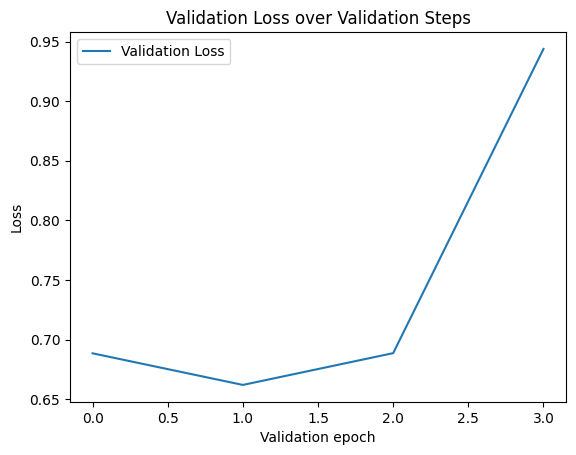

In [ ]:
plt.plot(range(len(valid_loss_values)), valid_loss_values, label='Validation Loss')
plt.xlabel('Validation epoch')
plt.ylabel('Loss')
plt.title('Validation Loss over Validation Steps')
plt.legend()
plt.show()

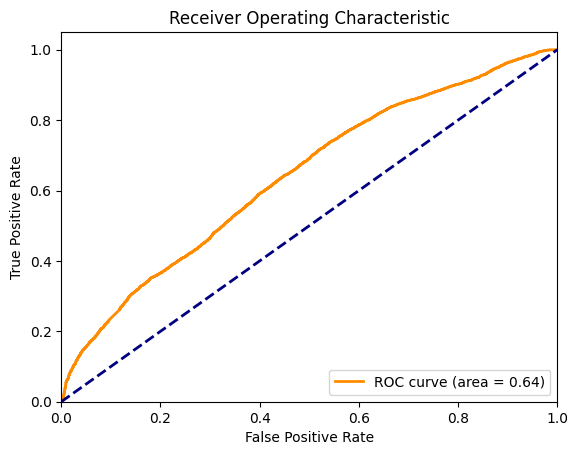

In [ ]:
# ROC 곡선 그리기
fpr, tpr, _ = roc_curve(roc_labels, roc_predictions)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

In [ ]:
tf.train.latest_checkpoint(checkpoint_dir)

test_losses = []

for data, diagnose, labels in valid_dataset_tensor:
    predictions = model([data, diagnose], training=False)
    test_loss = compute_loss(labels, predictions)
    test_losses.append(validation_loss.numpy())

mean_test_loss = np.mean(test_losses)
print("loss: {}".format(mean_test_loss))

loss: 0.5204580426216125


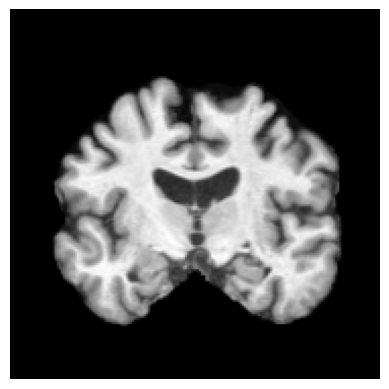

In [ ]:
# 이미지 로드
img_path="/content/drive/MyDrive/Colab Notebooks/Dementia_sample/Real_data/Mild AD/032_S_4755_121008/plane18.png"
# 이미지를 OpenCV로 읽어온 후, Matplotlib를 사용하여 표시
image = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)

# 이미지를 Matplotlib로 표시
plt.imshow(image, cmap='gray')
plt.axis('off')  # 축 숨김
plt.show()

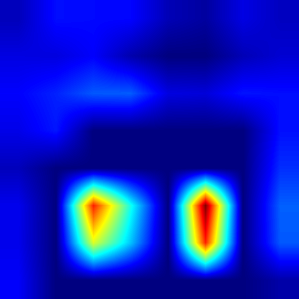

In [ ]:
class GradCAM:
    def __init__(self, model, layer_name):
        self.model = model
        self.layer_name = layer_name
        self.gradient_model = tf.keras.models.Model([model.inputs], [model.get_layer(layer_name).output, model.output])

    def compute_heatmap(self, image, class_index):
        with tf.GradientTape() as tape:
            conv_output, predictions = self.gradient_model(image)
            loss = predictions[:, class_index]

        grads = tape.gradient(loss, predictions)
        pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))
        conv_output = conv_output[0]

        heatmap = conv_output @ pooled_grads[..., tf.newaxis]
        heatmap = tf.squeeze(heatmap)

        heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
        return heatmap.numpy()

def load_and_process_image(image_path):
    image = cv2.imread(image_path, cv2.IMREAD_COLOR)
    image = cv2.resize(image, (299, 299))
    image = np.expand_dims(image, axis=0)
    return image

def generate_heatmap_for_patient(patient_folder, model, class_index=1, image_index=18):
    image_path = os.path.join(patient_folder, f"plane{image_index}.png")
    image = load_and_process_image(image_path)

    gradcam = GradCAM(model, 'conv_7b')
    heatmap = gradcam.compute_heatmap(image, class_index)

    heatmap_resized = cv2.resize(heatmap, (image.shape[2], image.shape[1]))
    heatmap_rescaled = (heatmap_resized * 255).astype(np.uint8).copy()
    heatmap_color = cv2.applyColorMap(heatmap_rescaled, cv2.COLORMAP_JET)

    return heatmap_color

def visualize_heatmap(heatmap_color):
    cv2_imshow( heatmap_color)
    cv2.waitKey(0)
    cv2.destroyAllWindows()

# 모델 로드
model_path = "/content/drive/MyDrive/Dataset/inception_resnet"
if 'full_model' not in globals():
    full_model = tf.keras.models.load_model(model_path)
model_CNN = full_model.pretrained_model.inception_res_partial

# 예측을 위한 폴더 경로 설정
folder_path = "/content/drive/MyDrive/Dataset/Real_data/Mild AD/002_S_0729_130816"

# 클래스 인덱스 선택 (음성 또는 양성)
class_index = 1

# 이미지 폴더에서 히트맵 생성
heatmap_color = generate_heatmap_for_patient(folder_path, model_CNN, class_index)

# 히트맵 이미지 출력
visualize_heatmap(heatmap_color)

In [ ]:
def inference(folder_path, gender, age_group, model_path,batch_size=30):
    #age_group은 0 :50, 1:60, 2:70, 3:80, 4:90 <--조심히 사용. age_group 범위는 0~4, gender 0or1
    image_paths = []
    image_numbers = []
    genders = []
    age_groups = []
  # 전역 변수로 full_model을 선언
    global full_model

    # full_model이 로드되어 있지 않다면 모델을 로드하고 전역 변수에 할당
    if 'full_model' not in globals():
        full_model = tf.keras.models.load_model(model_path)

    model_CNN = full_model.pretrained_model.inception_res_partial

    class GradCAM:
        def __init__(self, model, layer_name):
            self.model = model
            self.layer_name = layer_name
            self.gradient_model = tf.keras.models.Model([model.inputs], [model.get_layer(layer_name).output, model.output])

        def compute_heatmap(self, image, class_index):
            with tf.GradientTape() as tape:
                conv_output, predictions = self.gradient_model(image)
                loss = predictions[:, class_index]

            grads = tape.gradient(loss, predictions)
            pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))
            conv_output = conv_output[0]

            heatmap = conv_output @ pooled_grads[..., tf.newaxis]
            heatmap = tf.squeeze(heatmap)

            heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
            return heatmap.numpy()

    def load_and_process_image(image_path):
        image = cv2.imread(image_path, cv2.IMREAD_COLOR)
        image = cv2.resize(image, (299, 299))
        image = np.expand_dims(image, axis=0)
        return image

    def generate_heatmap_for_patient(patient_folder, model, class_index=1, image_index=18):
        image_path = os.path.join(patient_folder, f"plane{image_index}.png")
        image = load_and_process_image(image_path)

        gradcam = GradCAM(model, 'conv_7b')
        heatmap = gradcam.compute_heatmap(image, class_index)

        heatmap_resized = cv2.resize(heatmap, (image.shape[2], image.shape[1]))
        heatmap_rescaled = (heatmap_resized * 255).astype(np.uint8).copy()
        heatmap_color = cv2.applyColorMap(heatmap_rescaled, cv2.COLORMAP_JET)

        return heatmap_color

    def visualize_heatmap(heatmap_color):
        cv2_imshow( heatmap_color)
        cv2.waitKey(0)
        cv2.destroyAllWindows()

        # 이미지 로드 함수 정의
    def load_image(image_path, gender, age_group, image_number):
        image = tf.io.read_file(image_path)
        image = tf.image.decode_png(image, channels=3)  # PNG 이미지일 경우 channels=3으로 설정
        image = tf.image.resize(image, (299, 299))
        return image, (gender, age_group, image_number)
        #logits outputs
    def calculate_percentage(probabilities):
        neg_percentage = np.mean(probabilities[:, 0]) * 100.0
        pos_percentage = np.mean(probabilities[:, 1]) * 100.0
        return round(neg_percentage, 1), round(pos_percentage, 1)

    # 이미지 폴더에서 이미지 경로 수집
    for i in range(30):
        image_path = os.path.join(folder_path, f"plane{i}.png")
        image_paths.append(image_path)
        image_numbers.append(i)
        genders.append(gender)
        age_groups.append(age_group)

    # 데이터프레임 생성
    data = {
        'image_path': image_paths,
        'gender': genders,
        'age_group': age_groups,
        'image_number': image_numbers
    }
    df = pd.DataFrame(data)

    # 이미지 경로 및 라벨 추출
    image_paths = df['image_path'].values
    gender = tf.cast(df['gender'].values, tf.int64)
    age_group = tf.cast(df['age_group'].values, tf.int64)
    image_number = tf.cast(df['image_number'].values, tf.int64)


    # 데이터셋 생성
    dataset = tf.data.Dataset.from_tensor_slices((image_paths, gender, age_group, image_number))
    # 이미지 로드 및 전처리 적용
    dataset = dataset.map(load_image)
    # 배치 설정
    dataset = dataset.batch(batch_size)

    for images, diagnoses in dataset.take(1):
        logits = model([images,diagnoses])
    neg_percentage, pos_percentage = calculate_percentage(logits)

    print("음성 퍼센트:", neg_percentage)
    print("양성 퍼센트:", pos_percentage)


    # 클래스 인덱스 선택 (음성 또는 양성)
    class_index = 1

    # 이미지 폴더에서 히트맵 생성
    heatmap_color = generate_heatmap_for_patient(folder_path, model_CNN, class_index)

    # 히트맵 이미지 출력
    visualize_heatmap(heatmap_color)

    return heatmap_color,(neg_percentage,neg_percentage)


/usr/local/lib/python3.10/dist-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


음성 퍼센트: 74.0
양성 퍼센트: 26.0


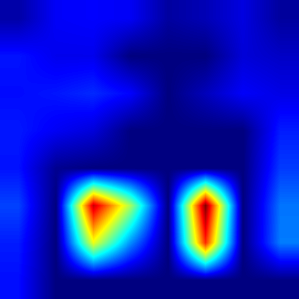

히트맵: [[[168   0   0]
  [168   0   0]
  [168   0   0]
  ...
  [156   0   0]
  [156   0   0]
  [156   0   0]]

 [[168   0   0]
  [168   0   0]
  [168   0   0]
  ...
  [156   0   0]
  [156   0   0]
  [156   0   0]]

 [[168   0   0]
  [168   0   0]
  [168   0   0]
  ...
  [156   0   0]
  [156   0   0]
  [156   0   0]]

 ...

 [[255  12   0]
  [255  12   0]
  [255  12   0]
  ...
  [132   0   0]
  [132   0   0]
  [132   0   0]]

 [[255  12   0]
  [255  12   0]
  [255  12   0]
  ...
  [132   0   0]
  [132   0   0]
  [132   0   0]]

 [[255  12   0]
  [255  12   0]
  [255  12   0]
  ...
  [132   0   0]
  [132   0   0]
  [132   0   0]]]
음성 및 양성 퍼센테지: (74.0, 74.0)


In [ ]:
folder_path = "/content/drive/MyDrive/Dataset/Dementia_sample/Real_data/Mild AD/002_S_0729_110816"
gender = 0
age_group = 0
model_path = "/content/drive/MyDrive/Dataset/inception_resnet"

heatmap_color, percentages = inference(folder_path, gender, age_group, model_path)
print("히트맵:", heatmap_color)
print("음성 및 양성 퍼센테지:", percentages)

In [ ]:
def create_dataset(folder_path, gender, age_group):
    image_paths = []
    image_numbers = []
    genders = []
    age_groups = []

    # 이미지 폴더에서 이미지 경로 수집
    for i in range(30):
        image_path = os.path.join(folder_path, f"plane{i}.png")
        image_paths.append(image_path)
        image_numbers.append(i)
        genders.append(gender)
        age_groups.append(age_group)

    # 데이터프레임 생성
    data = {
        'image_path': image_paths,
        'gender': genders,
        'age_group': age_groups,
        'image_number': image_numbers
    }
    df = pd.DataFrame(data)

    return df


    # 예시 데이터셋 생성
folder_path = "/content/drive/MyDrive/Dataset/Dementia_sample/Real_data/Mild AD/002_S_0729_110816"
gender = 0
age_group = 0

dataset = create_dataset(folder_path, gender, age_group)


def create_tf_dataset(dataframe, batch_size=30):
    # 이미지 경로 및 라벨 추출
    image_paths = dataframe['image_path'].values
    gender = tf.cast(dataframe['gender'].values, tf.int64)
    age_group = tf.cast(dataframe['age_group'].values, tf.int64)
    image_number = tf.cast(dataframe['image_number'].values, tf.int64)


    # 이미지 로드 함수 정의
    def load_image(image_path, gender, age_group, image_number):
        image = tf.io.read_file(image_path)
        image = tf.image.decode_png(image, channels=3)  # PNG 이미지일 경우 channels=3으로 설정
        image = tf.image.resize(image, (299, 299))


        return image, (gender, age_group, image_number)

    # 데이터셋 생성
    dataset = tf.data.Dataset.from_tensor_slices((image_paths, gender, age_group, image_number))
    # 이미지 로드 및 전처리 적용
    dataset = dataset.map(load_image)
    # 배치 설정
    dataset = dataset.batch(batch_size)

    return dataset

# 예시 데이터셋 생성
folder_path = "/content/drive/MyDrive/Dataset/Dementia_sample/Real_data/Mild AD/002_S_0729_110816"
gender = 0
age_group = 0

dataset = create_dataset(folder_path, gender, age_group)

tf_dataset = create_tf_dataset(dataset)

tf_dataset


def calculate_percentage(probabilities):
    neg_percentage = np.mean(probabilities[:, 0]) * 100.0
    pos_percentage = np.mean(probabilities[:, 1]) * 100.0
    return round(neg_percentage, 1), round(pos_percentage, 1)

for images, diagnoses in tf_dataset.take(1):
    logits=full_model([images,diagnoses])
neg_percentage, pos_percentage = calculate_percentage(logits)

print("음성 퍼센트:", neg_percentage)
print("양성 퍼센트:", pos_percentage)

/usr/local/lib/python3.10/dist-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


음성 퍼센트: 1.2
양성 퍼센트: 98.8


In [ ]:
def create_dataset_and_tf_dataset(folder_path, gender, age_group, batch_size=30):
    image_paths = []
    image_numbers = []
    genders = []
    age_groups = []

    # 이미지 폴더에서 이미지 경로 수집
    for i in range(30):
        image_path = os.path.join(folder_path, f"plane{i}.png")
        image_paths.append(image_path)
        image_numbers.append(i)
        genders.append(gender)
        age_groups.append(age_group)

    # 데이터프레임 생성
    data = {
        'image_path': image_paths,
        'gender': genders,
        'age_group': age_groups,
        'image_number': image_numbers
    }
    df = pd.DataFrame(data)

    # 이미지 경로 및 라벨 추출
    image_paths = df['image_path'].values
    gender = tf.cast(df['gender'].values, tf.int64)
    age_group = tf.cast(df['age_group'].values, tf.int64)
    image_number = tf.cast(df['image_number'].values, tf.int64)

    # 이미지 로드 함수 정의
    def load_image(image_path, gender, age_group, image_number):
        image = tf.io.read_file(image_path)
        image = tf.image.decode_png(image, channels=3)  # PNG 이미지일 경우 channels=3으로 설정
        image = tf.image.resize(image, (299, 299))

        return image, (gender, age_group, image_number)

    # 데이터셋 생성
    dataset = tf.data.Dataset.from_tensor_slices((image_paths, gender, age_group, image_number))
    # 이미지 로드 및 전처리 적용
    dataset = dataset.map(load_image)
    # 배치 설정
    dataset = dataset.batch(batch_size)

    return df, dataset




In [ ]:
for images, diagnoses in tf_dataset.take(1):
    logits=full_model([images,diagnoses])
logits

heatmap_rescaled:(299, 299)


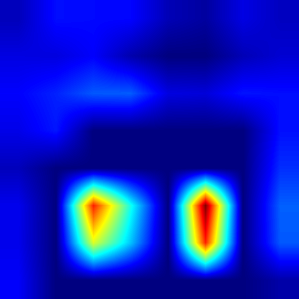

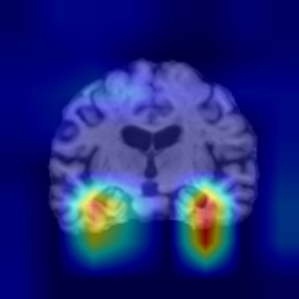

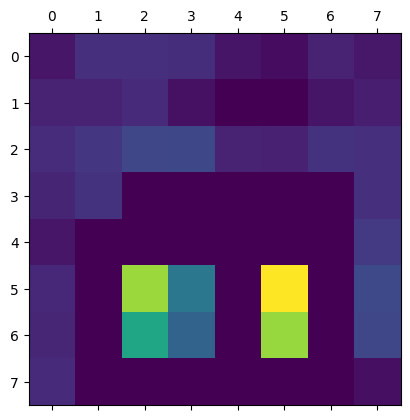

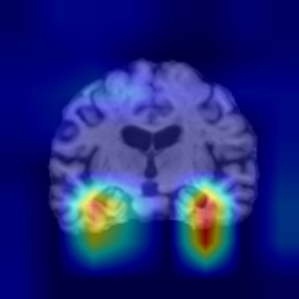

True

In [ ]:
class GradCAM:
    def __init__(self, model, layer_name):
        self.model = model
        self.layer_name = layer_name
        self.gradient_model = tf.keras.models.Model([model.inputs], [model.get_layer(layer_name).output, model.output])

    def compute_heatmap(self, image, class_index):
        with tf.GradientTape() as tape:
            conv_output, predictions = self.gradient_model(image)
            # print(f'conv_output.shape: {conv_output.shape}')
            # print(f'predictions.shape: {predictions.shape}')
            loss = predictions[:, class_index]
            # print(f'loss.shape: {loss.shape}')
            # print(loss)

        grads = tape.gradient(loss, predictions)
        # print(f'grads: {grads}')
        # print(f'grads.shape: {grads.shape}')
        pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))
        conv_output = conv_output[0]

        heatmap = conv_output @ pooled_grads[..., tf.newaxis]
        heatmap = tf.squeeze(heatmap)

        heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
        return heatmap.numpy()

#html
def overlay_heatmap(image, heatmap, alpha=0.5):
    heatmap_resized = cv2.resize(heatmap, (image.shape[1], image.shape[0]))
    heatmap_rescaled = (heatmap_resized * 255).astype(np.uint8).copy()
    print(f'heatmap_rescaled:{heatmap_rescaled.shape}')
    heatmap_color = cv2.applyColorMap(heatmap_rescaled, cv2.COLORMAP_JET)
    cv2_imshow(heatmap_color)
    overlay_img = cv2.addWeighted(heatmap_color, alpha, image, 1 - alpha, 0)
    cv2_imshow(overlay_img)
    overlay_img = np.minimum(overlay_img, 255.0).astype(np.uint8)
    return overlay_img

plane_number = 18
subject_number = '002_S_0729_130816'
# 이미지 로드
img_path=f"/content/drive/MyDrive/Dataset/Real_data/Mild AD/{subject_number}/plane{plane_number}.png"
# image = cv2.imread(img_path)
image = cv2.imread(img_path, cv2.IMREAD_COLOR)
image = cv2.resize(image, (299, 299))
image = np.expand_dims(image, axis=0)

# 모델 및 Grad-CAM 생성
if 'full_model' not in globals():
    full_model = tf.keras.models.load_model("/content/drive/MyDrive/Dataset/inception_resnet")
# defalut = 'conv_7b'
model_CNN = full_model.pretrained_model.inception_res_partial
gradcam = GradCAM(model_CNN, 'conv_7b')

# 클래스 인덱스 선택 (모델이 분류하는 클래스 중 하나)
class_index = 1

# eager execution 활성화
tf.config.experimental_run_functions_eagerly(True)
# 모델을 훈련 모드로 설정
tf.keras.backend.set_learning_phase(1)

# Grad-CAM 히트맵 생성
heatmap = gradcam.compute_heatmap(image, class_index)

# 원본 이미지에 히트맵 오버레이
overlay = overlay_heatmap(image[0], heatmap)




folder_path = f'/content/drive/MyDrive/Dataset/Grad_cam_img_folder/{subject_number}/'
# Check if the directory exists, if not, create it
if not os.path.exists(folder_path):
    os.makedirs(folder_path)
# 결과 표시
plt.matshow(heatmap)
plt.savefig(os.path.join(folder_path, f'heatmap{plane_number}.png'))
plt.show()
cv2_imshow(overlay)
cv2.imwrite(os.path.join(folder_path, f'overlay{plane_number}.png'),overlay)
### input 30장 -> 1. 음성, 양성(logits), 2. 히트맵(18번)

In [ ]:
for layer in full_model.pretrained_model.inception_res_partial.layers:
    print(layer.name)

input_3
conv2d_406
batch_normalization_406
activation_406
conv2d_407
batch_normalization_407
activation_407
conv2d_408
batch_normalization_408
activation_408
max_pooling2d_8
conv2d_409
batch_normalization_409
activation_409
conv2d_410
batch_normalization_410
activation_410
max_pooling2d_9
conv2d_414
batch_normalization_414
activation_414
conv2d_412
conv2d_415
batch_normalization_412
batch_normalization_415
activation_412
activation_415
average_pooling2d_2
conv2d_411
conv2d_413
conv2d_416
conv2d_417
batch_normalization_411
batch_normalization_413
batch_normalization_416
batch_normalization_417
activation_411
activation_413
activation_416
activation_417
mixed_5b
conv2d_421
batch_normalization_421
activation_421
conv2d_419
conv2d_422
batch_normalization_419
batch_normalization_422
activation_419
activation_422
conv2d_418
conv2d_420
conv2d_423
batch_normalization_418
batch_normalization_420
batch_normalization_423
activation_418
activation_420
activation_423
block35_1_mixed
block35_1_conv


In [ ]:
data=model_CNN(image)

In [ ]:
model.pretrained_model.inception_res_partial

In [ ]:
model_CNN = full_model.pretrained_model.inception_res_partial
model_CNN

In [ ]:
model_CNN.inputs

[<KerasTensor: shape=(None, 299, 299, 3) dtype=float32 (created by layer 'input_3')>]

In [ ]:
model_CNN.outputs

[<KerasTensor: shape=(None, 8, 8, 1536) dtype=float32 (created by layer 'conv_7b_ac')>]

In [ ]:
model_CNN.get_layer('conv_7b').output


<KerasTensor: shape=(None, 8, 8, 1536) dtype=float32 (created by layer 'conv_7b')>

In [ ]:
model_CNN.summary()

Model: "model_15"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_3 (InputLayer)        [(None, 299, 299, 3)]        0         []                            
                                                                                                  
 conv2d_406 (Conv2D)         (None, 149, 149, 32)         864       ['input_3[0][0]']             
                                                                                                  
 batch_normalization_406 (B  (None, 149, 149, 32)         96        ['conv2d_406[1][0]']          
 atchNormalization)                                                                               
                                                                                                  
 activation_406 (Activation  (None, 149, 149, 32)         0         ['batch_normalization_4

In [ ]:
model_CNN = full_model.pretrained_model
model_CNN.inception_res_partial.get_layer('conv2d_17').output

ValueError: No such layer: conv2d_17. Existing layers are: ['input_3', 'conv2d_406', 'batch_normalization_406', 'activation_406', 'conv2d_407', 'batch_normalization_407', 'activation_407', 'conv2d_408', 'batch_normalization_408', 'activation_408', 'max_pooling2d_8', 'conv2d_409', 'batch_normalization_409', 'activation_409', 'conv2d_410', 'batch_normalization_410', 'activation_410', 'max_pooling2d_9', 'conv2d_414', 'batch_normalization_414', 'activation_414', 'conv2d_412', 'conv2d_415', 'batch_normalization_412', 'batch_normalization_415', 'activation_412', 'activation_415', 'average_pooling2d_2', 'conv2d_411', 'conv2d_413', 'conv2d_416', 'conv2d_417', 'batch_normalization_411', 'batch_normalization_413', 'batch_normalization_416', 'batch_normalization_417', 'activation_411', 'activation_413', 'activation_416', 'activation_417', 'mixed_5b', 'conv2d_421', 'batch_normalization_421', 'activation_421', 'conv2d_419', 'conv2d_422', 'batch_normalization_419', 'batch_normalization_422', 'activation_419', 'activation_422', 'conv2d_418', 'conv2d_420', 'conv2d_423', 'batch_normalization_418', 'batch_normalization_420', 'batch_normalization_423', 'activation_418', 'activation_420', 'activation_423', 'block35_1_mixed', 'block35_1_conv', 'custom_scale_layer_80', 'block35_1_ac', 'conv2d_427', 'batch_normalization_427', 'activation_427', 'conv2d_425', 'conv2d_428', 'batch_normalization_425', 'batch_normalization_428', 'activation_425', 'activation_428', 'conv2d_424', 'conv2d_426', 'conv2d_429', 'batch_normalization_424', 'batch_normalization_426', 'batch_normalization_429', 'activation_424', 'activation_426', 'activation_429', 'block35_2_mixed', 'block35_2_conv', 'custom_scale_layer_81', 'block35_2_ac', 'conv2d_433', 'batch_normalization_433', 'activation_433', 'conv2d_431', 'conv2d_434', 'batch_normalization_431', 'batch_normalization_434', 'activation_431', 'activation_434', 'conv2d_430', 'conv2d_432', 'conv2d_435', 'batch_normalization_430', 'batch_normalization_432', 'batch_normalization_435', 'activation_430', 'activation_432', 'activation_435', 'block35_3_mixed', 'block35_3_conv', 'custom_scale_layer_82', 'block35_3_ac', 'conv2d_439', 'batch_normalization_439', 'activation_439', 'conv2d_437', 'conv2d_440', 'batch_normalization_437', 'batch_normalization_440', 'activation_437', 'activation_440', 'conv2d_436', 'conv2d_438', 'conv2d_441', 'batch_normalization_436', 'batch_normalization_438', 'batch_normalization_441', 'activation_436', 'activation_438', 'activation_441', 'block35_4_mixed', 'block35_4_conv', 'custom_scale_layer_83', 'block35_4_ac', 'conv2d_445', 'batch_normalization_445', 'activation_445', 'conv2d_443', 'conv2d_446', 'batch_normalization_443', 'batch_normalization_446', 'activation_443', 'activation_446', 'conv2d_442', 'conv2d_444', 'conv2d_447', 'batch_normalization_442', 'batch_normalization_444', 'batch_normalization_447', 'activation_442', 'activation_444', 'activation_447', 'block35_5_mixed', 'block35_5_conv', 'custom_scale_layer_84', 'block35_5_ac', 'conv2d_451', 'batch_normalization_451', 'activation_451', 'conv2d_449', 'conv2d_452', 'batch_normalization_449', 'batch_normalization_452', 'activation_449', 'activation_452', 'conv2d_448', 'conv2d_450', 'conv2d_453', 'batch_normalization_448', 'batch_normalization_450', 'batch_normalization_453', 'activation_448', 'activation_450', 'activation_453', 'block35_6_mixed', 'block35_6_conv', 'custom_scale_layer_85', 'block35_6_ac', 'conv2d_457', 'batch_normalization_457', 'activation_457', 'conv2d_455', 'conv2d_458', 'batch_normalization_455', 'batch_normalization_458', 'activation_455', 'activation_458', 'conv2d_454', 'conv2d_456', 'conv2d_459', 'batch_normalization_454', 'batch_normalization_456', 'batch_normalization_459', 'activation_454', 'activation_456', 'activation_459', 'block35_7_mixed', 'block35_7_conv', 'custom_scale_layer_86', 'block35_7_ac', 'conv2d_463', 'batch_normalization_463', 'activation_463', 'conv2d_461', 'conv2d_464', 'batch_normalization_461', 'batch_normalization_464', 'activation_461', 'activation_464', 'conv2d_460', 'conv2d_462', 'conv2d_465', 'batch_normalization_460', 'batch_normalization_462', 'batch_normalization_465', 'activation_460', 'activation_462', 'activation_465', 'block35_8_mixed', 'block35_8_conv', 'custom_scale_layer_87', 'block35_8_ac', 'conv2d_469', 'batch_normalization_469', 'activation_469', 'conv2d_467', 'conv2d_470', 'batch_normalization_467', 'batch_normalization_470', 'activation_467', 'activation_470', 'conv2d_466', 'conv2d_468', 'conv2d_471', 'batch_normalization_466', 'batch_normalization_468', 'batch_normalization_471', 'activation_466', 'activation_468', 'activation_471', 'block35_9_mixed', 'block35_9_conv', 'custom_scale_layer_88', 'block35_9_ac', 'conv2d_475', 'batch_normalization_475', 'activation_475', 'conv2d_473', 'conv2d_476', 'batch_normalization_473', 'batch_normalization_476', 'activation_473', 'activation_476', 'conv2d_472', 'conv2d_474', 'conv2d_477', 'batch_normalization_472', 'batch_normalization_474', 'batch_normalization_477', 'activation_472', 'activation_474', 'activation_477', 'block35_10_mixed', 'block35_10_conv', 'custom_scale_layer_89', 'block35_10_ac', 'conv2d_479', 'batch_normalization_479', 'activation_479', 'conv2d_480', 'batch_normalization_480', 'activation_480', 'conv2d_478', 'conv2d_481', 'batch_normalization_478', 'batch_normalization_481', 'activation_478', 'activation_481', 'max_pooling2d_10', 'mixed_6a', 'conv2d_483', 'batch_normalization_483', 'activation_483', 'conv2d_484', 'batch_normalization_484', 'activation_484', 'conv2d_482', 'conv2d_485', 'batch_normalization_482', 'batch_normalization_485', 'activation_482', 'activation_485', 'block17_1_mixed', 'block17_1_conv', 'custom_scale_layer_90', 'block17_1_ac', 'conv2d_487', 'batch_normalization_487', 'activation_487', 'conv2d_488', 'batch_normalization_488', 'activation_488', 'conv2d_486', 'conv2d_489', 'batch_normalization_486', 'batch_normalization_489', 'activation_486', 'activation_489', 'block17_2_mixed', 'block17_2_conv', 'custom_scale_layer_91', 'block17_2_ac', 'conv2d_491', 'batch_normalization_491', 'activation_491', 'conv2d_492', 'batch_normalization_492', 'activation_492', 'conv2d_490', 'conv2d_493', 'batch_normalization_490', 'batch_normalization_493', 'activation_490', 'activation_493', 'block17_3_mixed', 'block17_3_conv', 'custom_scale_layer_92', 'block17_3_ac', 'conv2d_495', 'batch_normalization_495', 'activation_495', 'conv2d_496', 'batch_normalization_496', 'activation_496', 'conv2d_494', 'conv2d_497', 'batch_normalization_494', 'batch_normalization_497', 'activation_494', 'activation_497', 'block17_4_mixed', 'block17_4_conv', 'custom_scale_layer_93', 'block17_4_ac', 'conv2d_499', 'batch_normalization_499', 'activation_499', 'conv2d_500', 'batch_normalization_500', 'activation_500', 'conv2d_498', 'conv2d_501', 'batch_normalization_498', 'batch_normalization_501', 'activation_498', 'activation_501', 'block17_5_mixed', 'block17_5_conv', 'custom_scale_layer_94', 'block17_5_ac', 'conv2d_503', 'batch_normalization_503', 'activation_503', 'conv2d_504', 'batch_normalization_504', 'activation_504', 'conv2d_502', 'conv2d_505', 'batch_normalization_502', 'batch_normalization_505', 'activation_502', 'activation_505', 'block17_6_mixed', 'block17_6_conv', 'custom_scale_layer_95', 'block17_6_ac', 'conv2d_507', 'batch_normalization_507', 'activation_507', 'conv2d_508', 'batch_normalization_508', 'activation_508', 'conv2d_506', 'conv2d_509', 'batch_normalization_506', 'batch_normalization_509', 'activation_506', 'activation_509', 'block17_7_mixed', 'block17_7_conv', 'custom_scale_layer_96', 'block17_7_ac', 'conv2d_511', 'batch_normalization_511', 'activation_511', 'conv2d_512', 'batch_normalization_512', 'activation_512', 'conv2d_510', 'conv2d_513', 'batch_normalization_510', 'batch_normalization_513', 'activation_510', 'activation_513', 'block17_8_mixed', 'block17_8_conv', 'custom_scale_layer_97', 'block17_8_ac', 'conv2d_515', 'batch_normalization_515', 'activation_515', 'conv2d_516', 'batch_normalization_516', 'activation_516', 'conv2d_514', 'conv2d_517', 'batch_normalization_514', 'batch_normalization_517', 'activation_514', 'activation_517', 'block17_9_mixed', 'block17_9_conv', 'custom_scale_layer_98', 'block17_9_ac', 'conv2d_519', 'batch_normalization_519', 'activation_519', 'conv2d_520', 'batch_normalization_520', 'activation_520', 'conv2d_518', 'conv2d_521', 'batch_normalization_518', 'batch_normalization_521', 'activation_518', 'activation_521', 'block17_10_mixed', 'block17_10_conv', 'custom_scale_layer_99', 'block17_10_ac', 'conv2d_523', 'batch_normalization_523', 'activation_523', 'conv2d_524', 'batch_normalization_524', 'activation_524', 'conv2d_522', 'conv2d_525', 'batch_normalization_522', 'batch_normalization_525', 'activation_522', 'activation_525', 'block17_11_mixed', 'block17_11_conv', 'custom_scale_layer_100', 'block17_11_ac', 'conv2d_527', 'batch_normalization_527', 'activation_527', 'conv2d_528', 'batch_normalization_528', 'activation_528', 'conv2d_526', 'conv2d_529', 'batch_normalization_526', 'batch_normalization_529', 'activation_526', 'activation_529', 'block17_12_mixed', 'block17_12_conv', 'custom_scale_layer_101', 'block17_12_ac', 'conv2d_531', 'batch_normalization_531', 'activation_531', 'conv2d_532', 'batch_normalization_532', 'activation_532', 'conv2d_530', 'conv2d_533', 'batch_normalization_530', 'batch_normalization_533', 'activation_530', 'activation_533', 'block17_13_mixed', 'block17_13_conv', 'custom_scale_layer_102', 'block17_13_ac', 'conv2d_535', 'batch_normalization_535', 'activation_535', 'conv2d_536', 'batch_normalization_536', 'activation_536', 'conv2d_534', 'conv2d_537', 'batch_normalization_534', 'batch_normalization_537', 'activation_534', 'activation_537', 'block17_14_mixed', 'block17_14_conv', 'custom_scale_layer_103', 'block17_14_ac', 'conv2d_539', 'batch_normalization_539', 'activation_539', 'conv2d_540', 'batch_normalization_540', 'activation_540', 'conv2d_538', 'conv2d_541', 'batch_normalization_538', 'batch_normalization_541', 'activation_538', 'activation_541', 'block17_15_mixed', 'block17_15_conv', 'custom_scale_layer_104', 'block17_15_ac', 'conv2d_543', 'batch_normalization_543', 'activation_543', 'conv2d_544', 'batch_normalization_544', 'activation_544', 'conv2d_542', 'conv2d_545', 'batch_normalization_542', 'batch_normalization_545', 'activation_542', 'activation_545', 'block17_16_mixed', 'block17_16_conv', 'custom_scale_layer_105', 'block17_16_ac', 'conv2d_547', 'batch_normalization_547', 'activation_547', 'conv2d_548', 'batch_normalization_548', 'activation_548', 'conv2d_546', 'conv2d_549', 'batch_normalization_546', 'batch_normalization_549', 'activation_546', 'activation_549', 'block17_17_mixed', 'block17_17_conv', 'custom_scale_layer_106', 'block17_17_ac', 'conv2d_551', 'batch_normalization_551', 'activation_551', 'conv2d_552', 'batch_normalization_552', 'activation_552', 'conv2d_550', 'conv2d_553', 'batch_normalization_550', 'batch_normalization_553', 'activation_550', 'activation_553', 'block17_18_mixed', 'block17_18_conv', 'custom_scale_layer_107', 'block17_18_ac', 'conv2d_555', 'batch_normalization_555', 'activation_555', 'conv2d_556', 'batch_normalization_556', 'activation_556', 'conv2d_554', 'conv2d_557', 'batch_normalization_554', 'batch_normalization_557', 'activation_554', 'activation_557', 'block17_19_mixed', 'block17_19_conv', 'custom_scale_layer_108', 'block17_19_ac', 'conv2d_559', 'batch_normalization_559', 'activation_559', 'conv2d_560', 'batch_normalization_560', 'activation_560', 'conv2d_558', 'conv2d_561', 'batch_normalization_558', 'batch_normalization_561', 'activation_558', 'activation_561', 'block17_20_mixed', 'block17_20_conv', 'custom_scale_layer_109', 'block17_20_ac', 'conv2d_566', 'batch_normalization_566', 'activation_566', 'conv2d_562', 'conv2d_564', 'conv2d_567', 'batch_normalization_562', 'batch_normalization_564', 'batch_normalization_567', 'activation_562', 'activation_564', 'activation_567', 'conv2d_563', 'conv2d_565', 'conv2d_568', 'batch_normalization_563', 'batch_normalization_565', 'batch_normalization_568', 'activation_563', 'activation_565', 'activation_568', 'max_pooling2d_11', 'mixed_7a', 'conv2d_570', 'batch_normalization_570', 'activation_570', 'conv2d_571', 'batch_normalization_571', 'activation_571', 'conv2d_569', 'conv2d_572', 'batch_normalization_569', 'batch_normalization_572', 'activation_569', 'activation_572', 'block8_1_mixed', 'block8_1_conv', 'custom_scale_layer_110', 'block8_1_ac', 'conv2d_574', 'batch_normalization_574', 'activation_574', 'conv2d_575', 'batch_normalization_575', 'activation_575', 'conv2d_573', 'conv2d_576', 'batch_normalization_573', 'batch_normalization_576', 'activation_573', 'activation_576', 'block8_2_mixed', 'block8_2_conv', 'custom_scale_layer_111', 'block8_2_ac', 'conv2d_578', 'batch_normalization_578', 'activation_578', 'conv2d_579', 'batch_normalization_579', 'activation_579', 'conv2d_577', 'conv2d_580', 'batch_normalization_577', 'batch_normalization_580', 'activation_577', 'activation_580', 'block8_3_mixed', 'block8_3_conv', 'custom_scale_layer_112', 'block8_3_ac', 'conv2d_582', 'batch_normalization_582', 'activation_582', 'conv2d_583', 'batch_normalization_583', 'activation_583', 'conv2d_581', 'conv2d_584', 'batch_normalization_581', 'batch_normalization_584', 'activation_581', 'activation_584', 'block8_4_mixed', 'block8_4_conv', 'custom_scale_layer_113', 'block8_4_ac', 'conv2d_586', 'batch_normalization_586', 'activation_586', 'conv2d_587', 'batch_normalization_587', 'activation_587', 'conv2d_585', 'conv2d_588', 'batch_normalization_585', 'batch_normalization_588', 'activation_585', 'activation_588', 'block8_5_mixed', 'block8_5_conv', 'custom_scale_layer_114', 'block8_5_ac', 'conv2d_590', 'batch_normalization_590', 'activation_590', 'conv2d_591', 'batch_normalization_591', 'activation_591', 'conv2d_589', 'conv2d_592', 'batch_normalization_589', 'batch_normalization_592', 'activation_589', 'activation_592', 'block8_6_mixed', 'block8_6_conv', 'custom_scale_layer_115', 'block8_6_ac', 'conv2d_594', 'batch_normalization_594', 'activation_594', 'conv2d_595', 'batch_normalization_595', 'activation_595', 'conv2d_593', 'conv2d_596', 'batch_normalization_593', 'batch_normalization_596', 'activation_593', 'activation_596', 'block8_7_mixed', 'block8_7_conv', 'custom_scale_layer_116', 'block8_7_ac', 'conv2d_598', 'batch_normalization_598', 'activation_598', 'conv2d_599', 'batch_normalization_599', 'activation_599', 'conv2d_597', 'conv2d_600', 'batch_normalization_597', 'batch_normalization_600', 'activation_597', 'activation_600', 'block8_8_mixed', 'block8_8_conv', 'custom_scale_layer_117', 'block8_8_ac', 'conv2d_602', 'batch_normalization_602', 'activation_602', 'conv2d_603', 'batch_normalization_603', 'activation_603', 'conv2d_601', 'conv2d_604', 'batch_normalization_601', 'batch_normalization_604', 'activation_601', 'activation_604', 'block8_9_mixed', 'block8_9_conv', 'custom_scale_layer_118', 'block8_9_ac', 'conv2d_606', 'batch_normalization_606', 'activation_606', 'conv2d_607', 'batch_normalization_607', 'activation_607', 'conv2d_605', 'conv2d_608', 'batch_normalization_605', 'batch_normalization_608', 'activation_605', 'activation_608', 'block8_10_mixed', 'block8_10_conv', 'custom_scale_layer_119', 'conv_7b', 'conv_7b_bn', 'conv_7b_ac'].

In [ ]:
full_model.summary()

Model: "concat_model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 pretrained_model_1 (pretra  multiple                  54336736  
 ined_model)                                                     
                                                                 
 dignose_model_1 (dignose_m  multiple                  512       
 odel)                                                           
                                                                 
 concatenate_3 (Concatenate  multiple                  0         
 )                                                               
                                                                 
 dense_5 (Dense)             multiple                  426240    
                                                                 
 dense_6 (Dense)             multiple                  32896     
                                                    

In [ ]:
# prompt: full_model.pretrained_model.inception_res_partial의Existing layers이름들을 보여줘

['input_1', 'conv2d_1', 'batch_normalization_1', 'activation_1', 'conv2d_2', 'batch_normalization_2', 'activation_2', 'conv2d_3', 'batch_normalization_3', 'activation_3', 'max_pooling2d_1', 'conv2d_4', 'batch_normalization_4', 'activation_4', 'conv2d_5', 'batch_normalization_5', 'activation_5', 'max_pooling2d_2', 'conv2d_9', 'batch_normalization_9', 'activation_9', 'conv2d_7', 'conv2d_10', 'batch_normalization_7', 'batch_normalization_10', 'activation_7', 'activation_10', 'average_pooling2d_1', 'conv2d_6', 'conv2d_8', 'conv2d_11', 'conv2d_12', 'batch_normalization_6', 'batch_normalization_8', 'batch_normalization_11', 'batch_normalization_12', 'activation_6', 'activation_8', 'activation_11', 'activation_12', 'mixed_5b', 'conv2d_13', 'batch_normalization_13', 'activation_13', 'conv2d_15', 'batch_normalization_15', 'activation_15', 'conv2d_14', 'conv2d_16', 'batch_normalization_14', 'batch_normalization_16', 'activation_14', 'activation_16', 'average_pooling2d_2', 'conv2d_17', 'batch_normalization_17', 'activation_17', 'mixed_6a', 'conv2d_18', 'batch_normalization_18', 'activation_18', 'conv2d_20', 'batch_normalization_20', 'activation_20', 'conv2d_19', 'conv2d_21', 'batch_normalization_19', 'batch_normalization_21', 'activation_19', 'activation_21', 'average_pooling2d_3', 'conv2d_22', 'batch_normalization_22', 'activation_22', 'mixed_7a', 'conv2d_23', 'batch_normalization_23', 'activation_23', 'conv2d_25', 'batch_normalization_25', 'activation_25', 'conv2d_24', 'conv2d_26', 'batch_normalization_24', 'batch_normalization_26', 'activation_24', 'activation_26', 'max_pooling2d_3', 'mixed_7b', 'conv2d_27', 'batch_normalization_27', 'activation_27', 'conv2d_29', 'batch_normalization_29', 'activation_29', 'conv2d_28', 'conv2d_30', 'batch_normalization_28', 'batch_normalization_30', 'activation_28', 'activation_30', 'max_pooling2d_4', 'mixed_8a', 'conv2d_31', 'batch_normalization_31', 'activation_31', 'conv2d_33', 'batch_normalization_33', 'activation_33', 'conv2d_32', 'conv2d_34', 'batch_normalization_32', 'batch_normalization_34', 'activation_32', 'activation_34', 'max_pooling2d_5', 'mixed_9a']


In [ ]:
class GradCAM:
    def __init__(self, model, layer_name):
        self.model = model
        self.layer_name = layer_name
        self.gradient_model = tf.keras.models.Model([model.inputs], [model.get_layer(layer_name).output, model.output])

    def compute_heatmap(self, image, class_index):
        with tf.GradientTape() as tape:
            conv_output, predictions = self.gradient_model(image)
            loss = predictions[:, class_index]

        grads = tape.gradient(loss, conv_output)
        pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))
        conv_output = conv_output[0]

        heatmap = conv_output @ pooled_grads[..., tf.newaxis]
        heatmap = tf.squeeze(heatmap)

        heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
        return heatmap.numpy()

def overlay_heatmap(image, heatmap, alpha=0.5):
    heatmap_resized = cv2.resize(heatmap, (image.shape[1], image.shape[0]))
    heatmap_rescaled = (heatmap_resized * 255).astype(np.uint8).copy()
    heatmap_color = cv2.applyColorMap(heatmap_rescaled, cv2.COLORMAP_JET)
    overlay_img = cv2.addWeighted(heatmap_color, alpha, image, 1 - alpha, 0)
    overlay_img = np.minimum(overlay_img, 255.0).astype(np.uint8)
    return overlay_img

plane_number = 15
subject_number = '005_S_0814_071127'
# 이미지 로드
img_path=f"/content/drive/MyDrive/Colab Notebooks/Dementia_sample/Real_data/Mild AD/{subject_number}/plane{plane_number}.png"
# image = cv2.imread(img_path)
image = cv2.imread(img_path, cv2.IMREAD_COLOR)
image = cv2.resize(image, (299, 299))
image = np.expand_dims(image, axis=0)

# 모델 및 Grad-CAM 생성
if 'full_model' not in globals():
    full_model =tf.keras.models.load_model('/content/drive/MyDrive/Dataset/before_augmentation_False/inception_resnet')
model_CNN = full_model.pretrained_model.inception_res_partial
gradcam = GradCAM(model_CNN, 'conv_7b')

# 클래스 인덱스 선택 (모델이 분류하는 클래스 중 하나)
class_index = 1

# eager execution 활성화
tf.config.experimental_run_functions_eagerly(True)
# 모델을 훈련 모드로 설정
tf.keras.backend.set_learning_phase(1)

# Grad-CAM 히트맵 생성
heatmap = gradcam.compute_heatmap(image, class_index)

# 원본 이미지에 히트맵 오버레이
overlay = overlay_heatmap(image[0], heatmap)

folder_path = f'/content/drive/MyDrive/Dataset/Grad_cam_img_folder/{subject_number}/'
# Check if the directory exists, if not, create it
if not os.path.exists(folder_path):
    os.makedirs(folder_path)
# 결과 표시
plt.matshow(heatmap)
plt.savefig(os.path.join(folder_path, f'heatmap{plane_number}.png'))
plt.show()
cv2_imshow(overlay)
cv2.imwrite(os.path.join(folder_path, f'overlay{plane_number}.png'), overlay)


/usr/local/lib/python3.10/dist-packages/keras/src/backend.py:452: UserWarning: `tf.keras.backend.set_learning_phase` is deprecated and will be removed after 2020-10-11. To update it, simply pass a True/False value to the `training` argument of the `__call__` method of your layer or model.
  warnings.warn(


ValueError: Attempt to convert a value (None) with an unsupported type (<class 'NoneType'>) to a Tensor.

In [ ]:
layers_list = model_CNN.layers

# Reverse the list of layers
reversed_layers_list = layers_list[::-1]

# Print the reversed layers list
for layer in reversed_layers_list:
    print(layer.name)

In [ ]:
from tensorflow.keras.utils import plot_model
plot_model(tf.keras.applications.InceptionResNetV2(include_top=False,weights='imagenet',input_shape=(299, 299, 3)), show_shapes=True)

# 이미지 Only 모델

In [ ]:
class Image_Only_model(tf.keras.Model):
    def __init__(self):
        super(Image_Only_model, self).__init__()
        self.inception_res_model = tf.keras.applications.InceptionResNetV2(include_top=False, weights='imagenet', input_shape=(299, 299, 3))

        for layer in self.inception_res_model.layers:
            layer.trainable = False

        self.inception_res_partial = models.Model(inputs=self.inception_res_model.input, outputs=self.inception_res_model.output)
        self.global_average_pooling = tf.keras.layers.GlobalAveragePooling2D()
        self.dropout = tf.keras.layers.Dropout(0.5)
        self.Dense1 = tf.keras.layers.Dense(256, activation='relu')
        self.Dense2 = tf.keras.layers.Dense(128, activation='relu')
        self.output_layer = tf.keras.layers.Dense(2, activation='softmax')

    def call(self, input):
        x = self.inception_res_partial(input)
        x = self.global_average_pooling(x)
        x = self.Dense1(x)
        x = self.Dense2(x)
        x = self.dropout(x)
        output = self.output_layer(x)
        return output

In [ ]:
IMAGE_model = Image_Only_model()

In [ ]:
for data, _, labels in train_dataset_tensor.take(1):
    print(data.shape)
    print(labels.shape)


(30, 299, 299, 3)
(30,)


In [ ]:
for data, _, labels in train_dataset_tensor.take(1):
    IMAGE_model(data)



In [ ]:
IMAGE_model.summary()

Model: "image__only_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inception_resnet_v2 (Funct  (None, 8, 8, 1536)        54336736  
 ional)                                                          
                                                                 
 model (Functional)          (None, 8, 8, 1536)        54336736  
                                                                 
 global_average_pooling2d (  multiple                  0         
 GlobalAveragePooling2D)                                         
                                                                 
 dropout (Dropout)           multiple                  0         
                                                                 
 dense (Dense)               multiple                  393472    
                                                                 
 dense_1 (Dense)             multiple            

In [ ]:
# 가중치 감쇠(weight decay) 설정
weight_decay = 6e-5
end_learning_rate = 5e-5
# 초기 학습률 설정
initial_learning_rate = 3e-4

# 학습률 감소 스케줄 설정
lr_decay_steps = 392 * 5  # 총 스텝 수 = 1 에폭당 스텝 수 * 총 에폭 수
lr_decay_rate = 0.1  # 학습률 감소 비율

# 최적화 알고리즘 및 학습률 스케줄링 설정
optimizer = tf.keras.optimizers.Adam(learning_rate=tf.keras.optimizers.schedules.ExponentialDecay(initial_learning_rate, lr_decay_steps, lr_decay_rate))

In [ ]:
loss = tf.keras.losses.SparseCategoricalCrossentropy()

In [ ]:
IMAGE_model.compile(optimizer=optimizer, loss=loss, metrics=['accuracy'])

In [ ]:
from tensorflow.keras.callbacks import ModelCheckpoint

In [ ]:
if use_colab:
    checkpoint_dir ='/content/drive/MyDrive/Dataset/Image_Only'
    if not os.path.isdir(checkpoint_dir):
        os.makedirs(checkpoint_dir)
else:
    checkpoint_dir = '/content/drive/MyDrive/Dataset/Image_Only'

In [ ]:
if not tf.io.gfile.exists(checkpoint_dir):
    tf.io.gfile.makedirs(checkpoint_dir)
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")

if is_train:
    checkpoint = tf.train.Checkpoint(optimizer=optimizer,
                                   model=IMAGE_model)
else:
    checkpoint = tf.train.Checkpoint(model=IMAGE_model)



In [ ]:
def compute_loss(labels, predictions):
    return tf.keras.losses.sparse_categorical_crossentropy(labels, predictions)

In [ ]:
num_epochs = 5

In [ ]:
# 손실 및 ROC 데이터 저장
train_loss_values = []
valid_loss_values = []
valid_step_values = []  # valid loss와 동일한 인덱스의 valid step 저장
roc_labels = []
roc_predictions = []
# save loss values for plot
loss_history = []
global_step = 0 # step 수 정의 (선택)
print_steps = 10 # tf.gradient_tape
save_epochs = 1 # tf.gradient_tape

# 에폭 반복
prev_validation_auc = 0.0
for epoch in range(num_epochs):
    start_time = time.time()
    print("\nStart of epoch %d" % (epoch+1,))

    # 한 에폭당 평균 손실 및 정확도 초기화
    epoch_train_loss_avg = tf.keras.metrics.Mean()
    epoch_train_accuracy = tf.keras.metrics.Accuracy()
    epoch_validation_losses = []
    epoch_validation_labels = []
    epoch_validation_predictions = []

    # 데이터셋 스텝 반복
    for step, (data, _, labels) in enumerate(train_dataset_tensor):
        with tf.GradientTape() as tape:
            predictions = IMAGE_model(data, training=True)
            loss = compute_loss(labels, predictions)

        gradients = tape.gradient(loss, IMAGE_model.trainable_variables)
        optimizer.apply_gradients(zip(gradients, IMAGE_model.trainable_variables))

        # 손실 및 정확도 기록
        epoch_train_loss_avg.update_state(loss)
        epoch_train_accuracy.update_state(labels, tf.argmax(predictions, axis=1))

        # 10 스텝마다 손실 값 저장
        if step % 10 == 0:
            train_loss_values.append(epoch_train_loss_avg.result())

        if step % print_steps == 0:
            current_lr = optimizer.learning_rate.numpy()
            print("Step {:03d}: Train Loss: {:.3f}, Train Accuracy: {:.3f}, Learning Rate: {:.7f}".format(step+1,
                                                                                                            epoch_train_loss_avg.result(),
                                                                                                            epoch_train_accuracy.result(),
                                                                                                            current_lr))
        #lr 모니터링 및 학습 중단
        current_lr = optimizer.learning_rate.numpy()
        if current_lr <=weight_decay:
            print("Learning rate {} is less than or equal to {}. Stopping training and saving the IMAGE_model.".format(current_lr,weight_decay))
            break  # 학습 중단

    # validation 데이터셋을 사용하여 모델 평가
    for valid_step,(data, _, labels) in enumerate(valid_dataset_tensor):
        predictions = IMAGE_model(data, training=False)
        validation_loss = compute_loss(labels, predictions)
        epoch_validation_losses.append(validation_loss.numpy())
        epoch_validation_labels.extend(labels.numpy())
        epoch_validation_predictions.extend(tf.argmax(predictions, axis=1).numpy())

        # ROC 커브를 위한 데이터 저장
        roc_labels.extend(labels.numpy())
        roc_predictions.extend(predictions.numpy()[:, 1])  # 1로 예측될 확률만 사용

    # 손실과 정확도 출력
    mean_train_loss = epoch_train_loss_avg.result()
    mean_validation_loss = np.mean(epoch_validation_losses)
    val_accuracy = accuracy_score(epoch_validation_labels, epoch_validation_predictions)
    confusion = confusion_matrix(epoch_validation_labels, epoch_validation_predictions)
    specificity = confusion[0, 0] / (confusion[0, 0] + confusion[0, 1])
    sensitivity = confusion[1, 1] / (confusion[1, 0] + confusion[1, 1])
    auc_score = roc_auc_score(epoch_validation_labels, epoch_validation_predictions)

    print("Epoch {}: Train Loss {:.3f}, Validation Loss {:.3f}".format(epoch+1, mean_train_loss, mean_validation_loss))
    print("Validation Accuracy: {:.3f}, Specificity: {:.3f}, Sensitivity: {:.3f}, AUC: {:.3f}".format(val_accuracy, specificity, sensitivity, auc_score))

    # 손실 값 저장
    valid_loss_values.append(mean_validation_loss)
    valid_step_values.append(valid_step)  # 현재 valid step 저장

    # 모델 저장 조건 확인
    if (epoch+1) % save_epochs == 0:
        if auc_score > prev_validation_auc:
            checkpoint.save(checkpoint_prefix)
            IMAGE_model.save('/content/drive/MyDrive/Dataset/before_augmentation_False/inception_resnet', save_format='tf')
            print("Model saved")
            prev_validation_auc = auc_score

    end_time = time.time() # 종료 시간 기록
    epoch_time = end_time - start_time # 1 에폭 당 소요된 시간 계산
    print("Time taken for epoch {}: {:.2f} seconds".format(epoch+1, epoch_time))

    if current_lr <= weight_decay:
      break # 에폭 반복 중단


Start of epoch 1


Step 001: Train Loss: 0.658, Train Accuracy: 0.600, Learning Rate: 0.0003000
Step 011: Train Loss: 0.928, Train Accuracy: 0.382, Learning Rate: 0.0002965
Step 021: Train Loss: 0.840, Train Accuracy: 0.416, Learning Rate: 0.0002930
Step 031: Train Loss: 0.794, Train Accuracy: 0.452, Learning Rate: 0.0002896
Step 041: Train Loss: 0.774, Train Accuracy: 0.443, Learning Rate: 0.0002862
Step 051: Train Loss: 0.761, Train Accuracy: 0.454, Learning Rate: 0.0002829
Step 061: Train Loss: 0.754, Train Accuracy: 0.457, Learning Rate: 0.0002796
Step 071: Train Loss: 0.748, Train Accuracy: 0.458, Learning Rate: 0.0002763
Step 081: Train Loss: 0.742, Train Accuracy: 0.457, Learning Rate: 0.0002731
Step 091: Train Loss: 0.741, Train Accuracy: 0.465, Learning Rate: 0.0002699
Step 101: Train Loss: 0.736, Train Accuracy: 0.473, Learning Rate: 0.0002667
Step 111: Train Loss: 0.735, Train Accuracy: 0.471, Learning Rate: 0.0002636
Step 121: Train Loss: 0.731, Train Accuracy: 0.487, Learning Rate: 0.0002606